In [ ]:
import pandas as pd
import numpy as np
import string
import spacy
import nltk
import re
from nltk.corpus import stopwords
from tqdm import tqdm as tq

## Modelling
from sklearn.metrics import classification_report , confusion_matrix , accuracy_score

## Pre-trained models for sentence embeddings
# from sentence_transformers import SentenceTransformer

## Load Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_df= pd.read_csv("/content/drive/MyDrive/UOttawa/NLP/Group_project/final_project/Dataset/training_data_cleaned.csv")
#test_df= pd.read_csv("/content/drive/MyDrive/UOttawa/NLP/Group_project/final_project/Dataset/test.csv")
#test_labels_df= pd.read_csv("/content/drive/MyDrive/UOttawa/NLP/Group_project/final_project/Dataset/sample_submission.csv")

## Feature engineering

1. Select the best sentence embedding pretrained model
2. Use the model confidence on the duplicated questions  

In [ ]:
# # Sentence transformers for sentence embeddings :: https://github.com/UKPLab/sentence-transformers
% pip install -U sentence-transformers

     |████████████████████████████████| 85 kB 5.2 MB/s 
     |████████████████████████████████| 2.6 MB 28.1 MB/s 
     |████████████████████████████████| 1.2 MB 34.4 MB/s 
     |████████████████████████████████| 43 kB 2.2 MB/s 
     |████████████████████████████████| 895 kB 58.3 MB/s 
     |████████████████████████████████| 3.3 MB 58.1 MB/s 
     |████████████████████████████████| 636 kB 56.8 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.0.0-py3-none-any.whl size=126709 sha256=d94847db1cb0acc3f5e7dcfc5d347713e3a9dfb70fc1324401f9cbdfd5b3f505
  Stored in directory: /root/.cache/pip/wheels/d1/c1/0f/faafd427f705c4b012274ba60d9a91d75830306811e1355293
Successfully built sentence-transformers
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
from sentence_transformers import SentenceTransformer, util

**Extract a sample from the dataset for feature tuning**

In [ ]:
## Take a random subset of the training data 10K (due to limited resources)

k_subset= 10000
train_subset = train_df.sample(k_subset)

questions1 = train_subset['question1'].values
questions2 = train_subset['question2'].values

In [ ]:
train_subset.is_duplicate.value_counts()

0    6232
1    3768
Name: is_duplicate, dtype: int64

In [ ]:
models_dir = ['paraphrase-MiniLM-L3-v2',
              'stsb-mpnet-base-v2',
              'paraphrase-mpnet-base-v2']

for dir in models_dir:
  print(dir)
  model = SentenceTransformer(dir, device='cuda') ## Use GPU to accelerate the model encoding
  #Compute embedding for both lists
  embeddings1 = model.encode(questions1, convert_to_tensor=True)
  embeddings2 = model.encode(questions2, convert_to_tensor=True)

  #Compute cosine-similarits
  cosine_scores = util.pytorch_cos_sim(embeddings1, embeddings2)
  col = '_'.join(dir.split('-')[:2])+'_cosine'
  train_subset[col] = [cosine_scores[i][i].tolist() for i in range(k_subset)]

paraphrase-MiniLM-L3-v2
stsb-mpnet-base-v2
paraphrase-mpnet-base-v2


In [ ]:
model_cols = ['paraphrase_MiniLM_cosine', 'stsb_mpnet_cosine', 'paraphrase_mpnet_cosine']

for col in model_cols:
  confidence_dups = train_subset[train_subset['is_duplicate']==1][col].mean()
  confidence_non_dups = train_subset[train_subset['is_duplicate']==0][col].mean()
  
  print(f'Model Confidence of the duplicates ({col}) = {confidence_dups}')

  print(f'Model Confidence of the non-duplicates ({col}) = {confidence_non_dups}\n\n')

Model Confidence of the duplicates (paraphrase_MiniLM_cosine) = 0.8479464698954626
Model Confidence of the non-duplicates (paraphrase_MiniLM_cosine) = 0.5580064015439138


Model Confidence of the duplicates (stsb_mpnet_cosine) = 0.8402853347281994
Model Confidence of the non-duplicates (stsb_mpnet_cosine) = 0.5479525331895995


Model Confidence of the duplicates (paraphrase_mpnet_cosine) = 0.8854321176443257
Model Confidence of the non-duplicates (paraphrase_mpnet_cosine) = 0.5785634213629066




**Best model confidence is paraphrase MiniLM**
- Because the model acheives the best tradeoff in average cosine similarities between duplicates and non-duplicates questions.
- It is the highest model in benchmark trained on DupQ benchmark which is the same problem for detecting duplicated questions in Quora dataset

## Model Training 

In [ ]:
## Ensure GPU is enabled with tensorflow

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13835550279630010899
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14509932544
locality {
  bus_id: 1
  links {
  }
}
incarnation: 10699680615644918744
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
]


In [ ]:
## Take a random subset of the training data 100K (due to limited resources )

k_subset= 100000
train_subset = train_df.sample(k_subset)

questions1 = train_subset['question1'].values
questions2 = train_subset['question2'].values

In [ ]:
model = SentenceTransformer('paraphrase-MiniLM-L3-v2', device='cuda') ## Use GPU to accelerate the model encoding

#Compute embedding for both lists
embeddings1 = model.encode(questions1, convert_to_tensor=True)
embeddings2 = model.encode(questions2, convert_to_tensor=True)

In [ ]:
from keras.models import Sequential
from keras.layers import Conv1D, SpatialDropout1D , LSTM
from keras.layers import Dropout , MaxPooling1D , Flatten , Dense, Embedding
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

### Train a deep dense model 

In [ ]:
input_shape = embeddings1.shape[1]

# define the keras model
model = Sequential()
model.add(Dense(24, input_dim=input_shape, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# summarize the model
print(model.summary())

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
Y= train_subset.is_duplicate.values
Y= Y.reshape((Y.shape[0], -1))

X= embeddings1 * embeddings2
X = np.array(X.tolist())
X.shape

(100000, 384)

In [ ]:
X_train, X_val, y_train, y_val  = train_test_split(X, Y, test_size=0.20, random_state=12)
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(80000, 384)
(80000, 1)
(20000, 384)
(20000, 1)


In [ ]:
history = model.fit(X_train, y_train, batch_size = 10, epochs = 50, validation_data = (X_val, y_val))

In [ ]:
# ## load pre-trained model 
# from tensorflow import keras
# model = keras.models.load_model('/content/drive/MyDrive/UOttawa/NLP/Group_project/final_project/models/dense_model/')

In [ ]:
# evaluate the model
loss, accuracy = model.evaluate(X_train, y_train, verbose=1)
print('Train Accuracy: %f' % (accuracy*100))

2500/2500 [==============================] - 4s 2ms/step - loss: 0.5144 - accuracy: 0.7939
Train Accuracy: 79.393750


In [ ]:
# evaluate the model
loss, accuracy = model.evaluate(X_val, y_val, verbose=1)
print('Test Accuracy: %f' % (accuracy*100))

625/625 [==============================] - 1s 1ms/step - loss: 0.5180 - accuracy: 0.7879
Test Accuracy: 78.794998


In [ ]:
predictions = model.predict_classes(X_val).flatten()

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [ ]:
print("\t\t Dense Model on Test Data\n")
print(classification_report(y_val, predictions))

		 Dense Model on Test Data

              precision    recall  f1-score   support

           0       0.82      0.85      0.83     12561
           1       0.73      0.68      0.71      7439

    accuracy                           0.79     20000
   macro avg       0.77      0.77      0.77     20000
weighted avg       0.79      0.79      0.79     20000



In [ ]:
model.save('dense_model')

In [ ]:
!zip -r dense_model.zip dense_model

### Error analysis

In [ ]:
train_subset['dense_model_predictions'] =  model.predict_classes(X).flatten()

In [ ]:
## Misclassification
train_subset[train_subset.is_duplicate!=train_subset.dense_model_predictions]

In [ ]:
train_subset.to_csv('dense_predictions_data.csv')

### Test the model on sample test-data

In [ ]:
_, X_test , _ ,y_test = train_test_split(train_df[['question1', 'question2']] , train_df['is_duplicate'], test_size=0.2, random_state=0)

In [ ]:
model_embedding = SentenceTransformer('paraphrase-MiniLM-L3-v2', device='cuda') ## Use GPU to accelerate the model encoding

questions1 = X_test['question1'].values
questions2 = X_test['question2'].values

#Compute embedding for both lists
embeddings1 = model_embedding.encode(questions1, convert_to_tensor=True)
embeddings2 = model_embedding.encode(questions2, convert_to_tensor=True)

In [ ]:
Y= y_test.values
Y= Y.reshape((Y.shape[0], -1))

X= embeddings1 * embeddings2
X = np.array(X.tolist())
X.shape

In [ ]:
# evaluate the model on sample test set
loss, accuracy = model.evaluate(X, Y, verbose=1)
print('Test Accuracy: %f' % (accuracy*100))

In [ ]:
import matplotlib.pyplot as plt

accuracy = history.history["accuracy"]
loss = history.history["loss"]

val_accuracy = history.history["val_accuracy"]
val_loss = history.history["val_loss"]

#plot
plt.plot(accuracy,'g',label='training accuracy')
plt.plot(val_accuracy, 'r', label='validation accuracy')
plt.legend()
plt.show()


plt.plot(loss,'g',label='training loss')
plt.plot(val_loss, 'r', label='validation loss')
plt.legend()
plt.show()

### Deeper model

In [ ]:
import pandas as pd 
import numpy as np
from tqdm import tqdm as tq
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import LSTM, Dense, Bidirectional
from tensorflow.keras.layers import Dropout, SpatialDropout1D, TimeDistributed,Flatten, MaxPooling1D , Conv1D , multiply
from tensorflow.keras.layers import Embedding

In [ ]:
train_df= pd.read_csv("/content/drive/MyDrive/UOttawa/NLP/Group_project/final_project/Dataset/training_data_cleaned.csv")

## Take a random subset of the training data 100K (due to limited resources )

k_subset= 100000
train_subset = train_df.sample(k_subset)

In [ ]:
#max len of clean data
max_len_q1 = np.max(train_subset["question1"].apply(lambda x: len(x.split())))
max_len_q2 = np.max(train_subset["question2"].apply(lambda x: len(x.split())))
max_len_q1, max_len_q2

(64, 238)

In [ ]:
MAX_NB_WORDS = 200000

tokenizer = Tokenizer(num_words = MAX_NB_WORDS)

tokenizer.fit_on_texts(list(train_subset["question1"].values.astype(str))+list(train_subset["question2"].values.astype(str)))


X_train_q1 = tokenizer.texts_to_sequences(train_subset["question1"].values.astype(str))
X_train_q1 = pad_sequences(X_train_q1, maxlen = 30, padding = 'post')

X_train_q2 = tokenizer.texts_to_sequences(train_subset["question2"].values.astype(str))
X_train_q2 = pad_sequences(X_train_q2, maxlen = 30, padding = 'post')

In [ ]:
# X_test_q1 = tokenizer.texts_to_sequences(test_data['q1'].ravel())
# X_test_q1 = pad_sequences(X_test_q1,maxlen = 30, padding='post')

# X_test_q2 = tokenizer.texts_to_sequences(test_data['q2'].astype(str).ravel())
# X_test_q2 = pad_sequences(X_test_q2, maxlen = 30, padding='post')

In [ ]:
y = train_subset['is_duplicate']

In [ ]:
vocab_size = len(tokenizer.word_index) + 1

In [ ]:
## Download Glove pre-trained model when needed ##

!wget http://nlp.stanford.edu/data/glove.6B.zip
import zipfile
zip_ref = zipfile.ZipFile('glove.6B.zip', 'r')
zip_ref.extractall('golve/')
zip_ref.close()

--2021-07-25 01:31:06--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-07-25 01:31:06--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-07-25 01:31:06--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [ ]:
embeddings_index = {}
glovefile = open('golve/glove.6B.200d.txt','r',encoding='utf-8')
for line in tq(glovefile):
    values = line.split(" ")
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
#     coefs.shape
    embeddings_index[word] = coefs
glovefile.close()

print('Found %s word vectors.' % len(embeddings_index))

400000it [00:18, 21955.61it/s]

Found 400000 word vectors.


In [ ]:
#creating embedding matrix for the words we have in the dataset
embedding_matrix = np.zeros((len(tokenizer.word_index)+1, 200))
for words, index in tq(tokenizer.word_index.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

100%|██████████| 53850/53850 [00:00<00:00, 694942.53it/s]


In [ ]:
X_train_q1,X_valid_q1, X_train_q2, X_valid_q2, y_train, y_valid = train_test_split(X_train_q1, X_train_q2, y, test_size=0.20, random_state=12)
print(X_train_q1.shape, X_train_q2.shape, y_train.shape)
print(X_valid_q1.shape, X_valid_q2.shape, y_valid.shape)

(80000, 30) (80000, 30) (80000,)
(20000, 30) (20000, 30) (20000,)


In [ ]:
# Model for Question1

model_q1 = Sequential([Embedding(input_dim = vocab_size,output_dim = 200,weights = [embedding_matrix],input_length = 30, name='Question1_embedding'),
                      LSTM(128, activation = 'tanh', return_sequences = True),
                      Dropout(0.2),
                      Conv1D(8, 5, activation='relu'),
                      MaxPooling1D(pool_size=4),
                      LSTM(128, return_sequences = True),
                      LSTM(128),
                      Dense(60, activation = 'tanh'),

                      Dense(2, activation = 'sigmoid')])

In [ ]:
# Model for Question2

model_q2 = Sequential([Embedding(input_dim = vocab_size,output_dim = 200,weights = [embedding_matrix],input_length = 30, name='Question2_embedding'),
                      LSTM(128, activation = 'tanh', return_sequences = True),
                      Dropout(0.2),
                      Conv1D(8, 5, activation='relu'),
                      MaxPooling1D(pool_size=4),
                      LSTM(128, return_sequences = True),
                      LSTM(128),
                      Dense(60, activation = 'tanh'),
                      Dense(2, activation = 'sigmoid')])

In [ ]:
# Merging the output of the two models,i.e, model_q1 and model_q2
mergedOut = multiply([model_q1.output, model_q2.output])

mergedOut = Flatten()(mergedOut)
mergedOut = Dense(100, activation = 'relu')(mergedOut)
mergedOut = Dropout(0.2)(mergedOut)
mergedOut = Dense(50, activation = 'relu')(mergedOut)
mergedOut = Dropout(0.2)(mergedOut)
mergedOut = Dense(2, activation = 'sigmoid')(mergedOut)

In [ ]:
new_model = tf.keras.Model([model_q1.input, model_q2.input], mergedOut)
new_model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy',
                 metrics = ['accuracy'])

In [ ]:
new_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Question1_embedding_input (Inpu [(None, 30)]         0                                            
__________________________________________________________________________________________________
Question2_embedding_input (Inpu [(None, 30)]         0                                            
__________________________________________________________________________________________________
Question1_embedding (Embedding) (None, 30, 200)      10770200    Question1_embedding_input[0][0]  
__________________________________________________________________________________________________
Question2_embedding (Embedding) (None, 30, 200)      10770200    Question2_embedding_input[0][0]  
______________________________________________________________________________________________

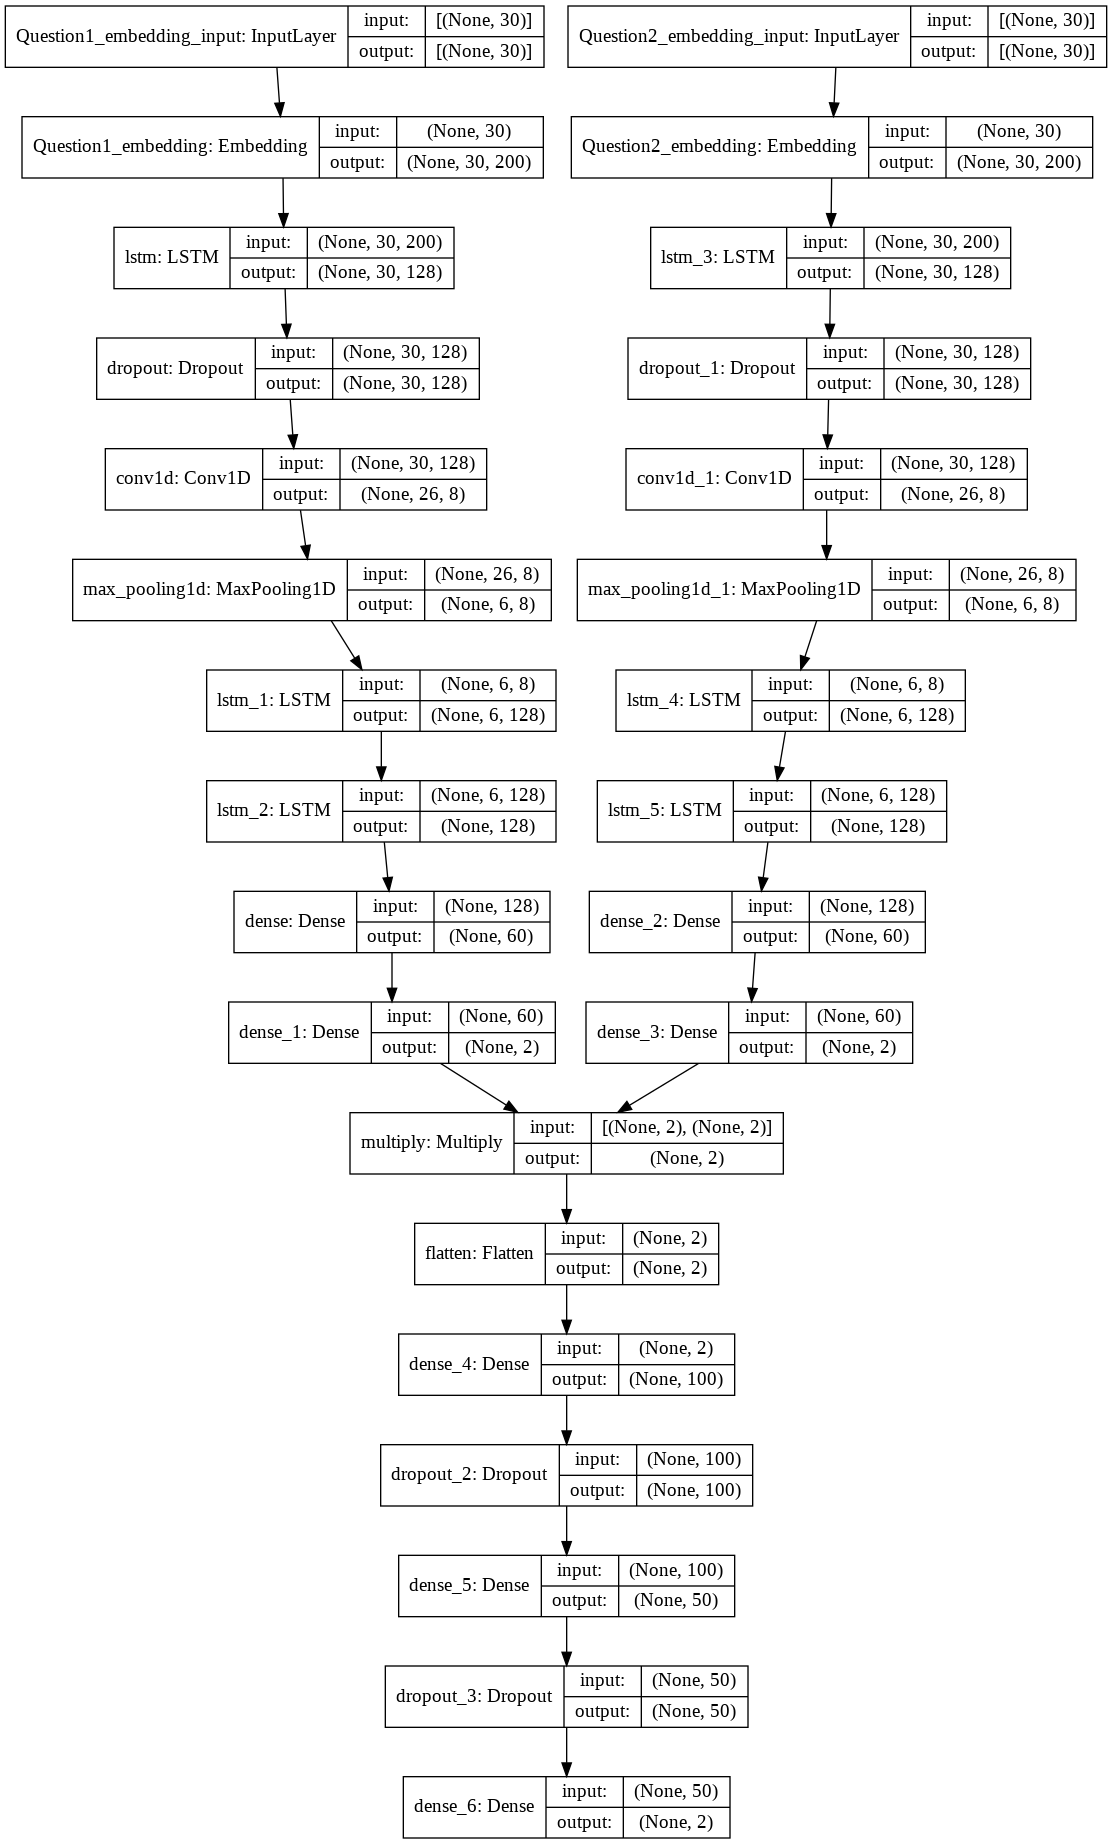

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(new_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
history = new_model.fit([X_train_q1,X_train_q2],y_train, batch_size = 100, epochs = 30, validation_data = ([X_valid_q1,X_valid_q2],y_valid))

Epoch 1/30
800/800 [==============================] - 206s 212ms/step - loss: 0.6193 - accuracy: 0.6540 - val_loss: 0.5724 - val_accuracy: 0.7082
Epoch 2/30
800/800 [==============================] - 167s 209ms/step - loss: 0.5424 - accuracy: 0.7303 - val_loss: 0.5497 - val_accuracy: 0.7278
Epoch 3/30
800/800 [==============================] - 168s 210ms/step - loss: 0.4817 - accuracy: 0.7716 - val_loss: 0.5862 - val_accuracy: 0.7249
Epoch 4/30
800/800 [==============================] - 168s 210ms/step - loss: 0.4241 - accuracy: 0.8061 - val_loss: 0.6047 - val_accuracy: 0.7175
Epoch 5/30
800/800 [==============================] - 168s 210ms/step - loss: 0.3690 - accuracy: 0.8375 - val_loss: 0.6043 - val_accuracy: 0.7181
Epoch 6/30
800/800 [==============================] - 166s 208ms/step - loss: 0.3211 - accuracy: 0.8591 - val_loss: 0.6916 - val_accuracy: 0.6969
Epoch 7/30
800/800 [==============================] - 167s 209ms/step - loss: 0.2774 - accuracy: 0.8803 - val_loss: 0.7499 -

In [ ]:
# evaluate the model on train data
loss, accuracy = new_model.evaluate([X_train_q1,X_train_q2],y_train, verbose=1)
print('Train Accuracy: %f' % (accuracy*100))

2500/2500 [==============================] - 22s 8ms/step - loss: 0.0258 - accuracy: 0.9900
Train Accuracy: 98.998749


In [ ]:
# evaluate the model on train data
loss, accuracy = new_model.evaluate([X_valid_q1,X_valid_q2],y_valid, verbose=1)
print('Test Accuracy: %f' % (accuracy*100))

625/625 [==============================] - 5s 8ms/step - loss: 2.1734 - accuracy: 0.7004
Test Accuracy: 70.039999


In [ ]:
predictions = new_model.predict([X_valid_q1, X_valid_q2])

In [ ]:
sum(predictions, axis=1)==y_valid)/len(y_valid)

0.7004

In [ ]:
predictions = np.argmax(new_model.predict([X_valid_q1,X_valid_q2]), axis=1)

print("\t\t Deeper Model on Test Data\n")
print(classification_report(y_valid, predictions))

train_subset['deeper_model_predictions'] =  np.argmax(new_model.predict([X_train_q1,X_train_q2]), axis=1) 

## Misclassification
train_subset[train_subset.is_duplicate!=train_subset.deeper_model_predictions]

train_subset.to_csv('deeper_predictions_data.csv')

		 Deeper Model on Test Data

              precision    recall  f1-score   support

           0       0.79      0.72      0.75     12639
           1       0.58      0.67      0.62      7361

    accuracy                           0.70     20000
   macro avg       0.68      0.69      0.69     20000
weighted avg       0.71      0.70      0.70     20000



In [ ]:
new_model.save('deep_model')

In [ ]:
!zip -r deep_model.zip deep_model

  adding: deep_model/ (stored 0%)
  adding: deep_model/keras_metadata.pb (deflated 94%)
  adding: deep_model/assets/ (stored 0%)
  adding: deep_model/saved_model.pb (deflated 90%)
  adding: deep_model/variables/ (stored 0%)
  adding: deep_model/variables/variables.index (deflated 74%)
  adding: deep_model/variables/variables.data-00000-of-00001 (deflated 40%)


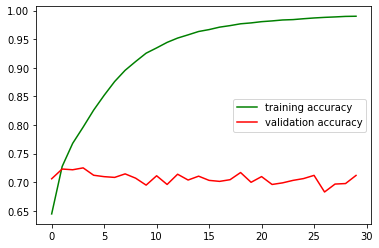

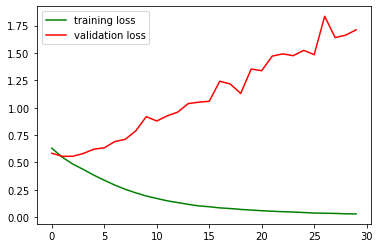

In [ ]:
import matplotlib.pyplot as plt

accuracy = history.history["accuracy"]
loss = history.history["loss"]

val_accuracy = history.history["val_accuracy"]
val_loss = history.history["val_loss"]

#plot 
plt.plot(accuracy,'g',label='training accuracy')
plt.plot(val_accuracy, 'r', label='validation accuracy')
plt.legend()
plt.show()


plt.plot(loss,'g',label='training loss')
plt.plot(val_loss, 'r', label='validation loss')
plt.legend()
plt.show()

### Test the model

In [ ]:
from tensorflow import keras
model = keras.models.load_model('/content/drive/MyDrive/UOttawa/NLP/Group_project/final_project/models/deep_model/')

In [1]:
# loss, accuracy = model.evaluate([X_valid_q1, X_valid_q2], y_valid, verbose=1)
# print('Test Accuracy: %f' % (accuracy*100))